# DEA Geomedian and Median Absolute Deviations  <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls5t_nbart_gm_cyear_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls5t_nbart_gm_cyear_3), 
[ga_ls7e_nbart_gm_cyear_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls7e_nbart_gm_cyear_3), [ga_ls8c_nbart_gm_cyear_3](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls8c_nbart_gm_cyear_3)

## Background

Satellite imagery allows us to observe the Earth with significant accuracy and detail. 
However, missing data (such as gaps caused by cloud cover) can make it difficult to put together a complete image. 
To produce a single, complete view of a certain area, satellite data must be consolidated, stacking measurements from different points in time to create a composite image. 

The Digital Earth Australia **Geo**median and **M**edian **A**bsolute **D**eviations (DEA GeoMAD) is a cloud-free composite of satellite data compiled for each calendar year.

The following GeoMAD products are available on DEA platforms:
* `ga_ls8c_nbart_gm_cyear_3`: Annual (calendar year) GeoMAD composite using Landsat-8 imagery, available for the years 2013 to present 
* `ga_ls7e_nbart_gm_cyear_3`: Annual (calendar year) GeoMAD composite using Landsat-7 imagery, available for the years 1999 to 2021 
* `ga_ls5t_nbart_gm_cyear_3`: Annual (calendar year) GeoMAD composite using Landsat-5, available for the years 1986 to 2011

Each product combines measurements collected over each calendar year to produce one representative, multi-spectral image for every pixel of the Australian continent. 
The final product is a comprehensive dataset that serves many purposes: it can be used to generate true-color images for visual landscape inspection, or the complete spectral dataset can be used for the development of more advanced algorithms.

To produce a geomedian composite, for each pixel, invalid data is discarded, and the remaining observations are mathematically summarised using a high-dimensional geomedian statistic.
GeoMAD also includes three measures of Median Absolute Deviation (MAD). 
These are higher-order statistical measurements on variation relative to the geomedian, pre-calculated at the same annual time scale. 
These layers can be used on their own or together with the geomedian to gain insights about the land surface and understand its change over time. 

For more information, visit the [DEA Geometric Median and Median Absolute Deviation product page](https://cmi.ga.gov.au/data-products/dea/645/dea-geometric-median-and-median-absolute-deviation-landsat). 


### Applications
The DEA GeoMAD product can be used to:
* generate land cover maps
* measure or detect change in classifications (such as burn area mapping, crop mapping, urban area mapping)
* environmental monitoring.

### Publications 

* Roberts, D., Mueller, N., & Mcintyre, A. (2017). High-dimensional pixel composites from earth observation time series. <i>IEEE Transactions on Geoscience and Remote Sensing</i>, 55(11), 6254–6264. https://doi.org/10.1109/TGRS.2017.2723896

* Roberts, D., Dunn, B., & Mueller, N. (2018). Open data cube products using high-dimensional statistics of time series. <i>IGARSS 2018 - 2018 IEEE International Geoscience and Remote Sensing Symposium</i>, 8647–8650. https://doi.org/10.1109/IGARSS.2018.8518312

## Description
In this notebook we will load GeoMAD data using dc.load() to return a time series of satellite images. 
The returned xarray.Dataset will contain analysis-ready images.

Topics covered include:

1. Inspecting the GeoMAD products and measurements available in the datacube
2. Using the native dc.load() function to load in GeoMAD data
    * Geomedian surface reflectance example
    * Median Absolute Deviations example
3. A simple example anlaysis using GeoMAD
4. An interactive widget for understanding the geomedian statistic

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import sys
sys.path.insert(1, "../Tools/")
from dea_tools.app import geomedian
from dea_tools.plotting import rgb

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", None)

### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app="DEA_GeoMAD")

## Available GeoMAD products and measurements

### List products and measurements
We can use datacube's `list_products` functionality to inspect the DEA GeoMAD products that are available in the datacube. 
The table below shows the product names that we will use to load the data and a brief description.

In [3]:
dc_products = dc.list_products()
display_columns = ["name", "description"]
dc_products[dc_products.name.str.contains("gm").fillna(False)][
    display_columns
].set_index("name")

,description
name,
ga_ls5t_nbart_gm_cyear_3,"Geoscience Australia Landsat Nadir BRDF Adjusted Reflectance Terrain, Landsat 5 Geomedian Calendar Year Collection 3"
ga_ls7e_nbart_gm_cyear_3,"Geoscience Australia Landsat Nadir BRDF Adjusted Reflectance Terrain, Landsat 7 Geomedian Calendar Year Collection 3"
ga_ls8c_nbart_gm_cyear_3,"Geoscience Australia Landsat Nadir BRDF Adjusted Reflectance Terrain, Landsat 8 Geomedian Calendar Year Collection 3"


We can further inspect the data available for GeoMAD using datacube's `list_measurements` functionality. 
The table below lists each of the measurements available in the data.

Below, enter the name of the product you would like to see the measurements of. 
In the default example, we will examine ga_ls8c_nbart_gm_cyear_3, the Landsat 8 GeoMAD product.

In [4]:
product = "ga_ls8c_nbart_gm_cyear_3"

measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
blue,blue,int16,1,-999,NaN,NaN
green,green,int16,1,-999,NaN,NaN
red,red,int16,1,-999,NaN,NaN
nir,nir,int16,1,-999,NaN,NaN
swir1,swir1,int16,1,-999,NaN,NaN
swir2,swir2,int16,1,-999,NaN,NaN
sdev,sdev,float32,1,NaN,NaN,NaN
edev,edev,float32,1,NaN,NaN,NaN
bcdev,bcdev,float32,1,NaN,NaN,NaN


## Load GeoMAD data using dc.load()
Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

### Example 1: Surface reflectance 

In the first example below, we will load GeoMAD data over Broome, Western Australia, from 2020. 
We will load data from three spectral satellite bands: red, green, and blue.

In [5]:
# coordinates for Broome, Western Australia
lat = -18.10
lon = 122.32
lat_buffer = 0.18
lon_buffer = 0.18

# combine central coordinates with buffer values to create the latitude and longitude range for the analysis
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# load data
ds = dc.load(
    product="ga_ls8c_nbart_gm_cyear_3",
    measurements=["red", "green", "blue"],
    x=lon_range,
    y=lat_range,
    time=("2020"),
)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, y: 1422, x: 1367)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -1.951e+06 -1.951e+06 ... -1.993e+06 -1.993e+06
  * x            (x) float64 -1.044e+06 -1.044e+06 ... -1.003e+06 -1.003e+06
    spatial_ref  int32 3577
Data variables:
    red          (time, y, x) int16 242 237 236 241 242 ... 1120 1159 1165 1113
    green        (time, y, x) int16 471 463 461 468 470 ... 805 795 808 808 790
    blue         (time, y, x) int16 561 555 555 558 561 ... 504 500 504 502 496
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


#### Plotting GeoMAD geomedian data
We can plot the data we loaded using the `dea_tools.plotting.rgb()` function.

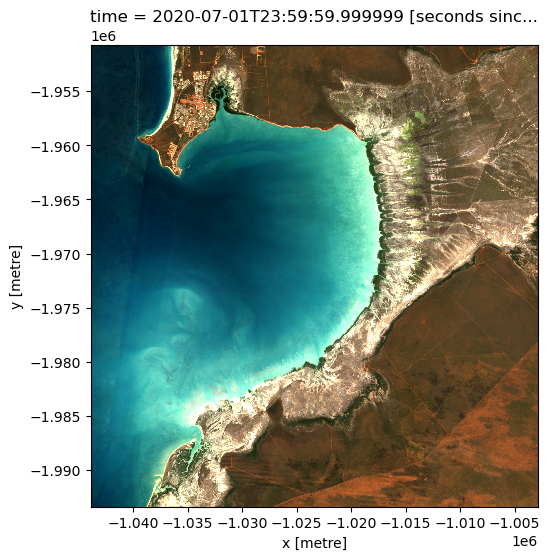

In [6]:
rgb(ds, bands=["red", "green", "blue"])

### Example 2: Median Absolute Deviations
In this example, we load the Median Absolute Deviation (MAD) bands of data and plot a false-colour map using those three bands. 
The region selected a farming area in Victoria. 

In [7]:
# coordinates for AOI
lat, lon = -34.27566, 145.87389
buffer = 0.05

# combine central coordinates with buffer values to create the latitude and longitude range for the analysis
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# load data
ds = dc.load(
    product="ga_ls8c_nbart_gm_cyear_3",
    measurements=["red", "green", "blue", "sdev", "edev", "bcdev"],
    x=(lon - buffer, lon + buffer),
    y=(lat + buffer, lat - buffer),
    time=("2015"),
)
print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, y: 404, x: 345)
Coordinates:
  * time         (time) datetime64[ns] 2015-07-02T11:59:59.999999
  * y            (y) float64 -3.804e+06 -3.804e+06 ... -3.816e+06 -3.816e+06
  * x            (x) float64 1.264e+06 1.264e+06 ... 1.274e+06 1.274e+06
    spatial_ref  int32 3577
Data variables:
    red          (time, y, x) int16 1082 1114 1176 1161 ... 1047 1087 1111 1052
    green        (time, y, x) int16 787 866 883 837 841 ... 844 815 830 851 814
    blue         (time, y, x) int16 524 559 579 550 560 ... 611 579 591 603 575
    sdev         (time, y, x) float32 0.001115 0.004531 ... 0.0008823 0.001321
    edev         (time, y, x) float32 592.6 579.7 781.2 ... 690.2 648.0 668.2
    bcdev        (time, y, x) float32 0.07006 0.07052 ... 0.07065 0.08706
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


#### Plotting GeoMAD MAD data
MAD data has three bands (SMAD, EMAD, BCMAD) and is therefore well-suited to being visualised in false-colour. 
This means each of the MADs is assigned to one of the red, green, and blue colour channels of the image.

Inspecting the xarray.Dataset above, we can see that the scaling of `sdev (0-1)`, `edev (0-10,000)` and `bcdev (0-1)` all have very different orders of magnitude. 
That means if we plot them as a three band RGB image (i.e. specifying the argument `rgb(bands=["edev", "sdev", "bcdev"]`) for false-colour), the larger values in `edev` will oversaturate the image (try it!).

To compensate for the different ranges in the dataset, we can scale the data for each of the three bands according to the range of values present in that band. 
This brings all the MADs to approximately the same range of values. 
The plot will then represent each MAD more equally, allowing features with high variability in all three measures to be readily identified by visual inspection.

There are two types of scaling: fixed, and dynamic.

Fixed scaling is useful when you are comparing multiple areas and want to have the same scale on each. 
It is used in the GeoMAD WMS layer and [Digital Earth Australia Maps](https://maps.dea.ga.gov.au/) portal for the MADs data.
 
In this notebook, we will demonstrate a dynamic scale. 
This scale is automatically adjusted depending on the area of interest selected, and on the range of data values for each of the MADs. 
This is more suitable when investigating a certain area of interest as the scale is tailored to the data contained in that area.

The dynamic scale here uses a `log` function to transform each MAD data point. 
The range is cut off at the 2nd and 98th percentiles, removing extreme outliers.

In [8]:
sdev_scaling = [
    np.log(ds.sdev.quantile(0.02).values),
    np.log(ds.sdev.quantile(0.98).values),
]
edev_scaling = [
    np.log(ds.edev.quantile(0.02).values),
    np.log(ds.edev.quantile(0.98).values),
]
bcdev_scaling = [
    np.log(ds.bcdev.quantile(0.02).values),
    np.log(ds.bcdev.quantile(0.98).values),
]

In this case, for each MAD we have used the scaling:

\begin{align*}
\text{MAD}_{\text{scaled}} = \frac{\log{\text{MAD}} -  \log \text{MAD}_{\text{2 percentile}}}{\log \text{MAD}_{\text{98 percentile}} - \log \text{MAD}_{\text{2 percentile}}}
\end{align*}

This is just one example of scaling that can be used to transform the MADs data to a common order of magnitude, without skewing the data. Scaling can be adjusted to suit the purpose or application of the data.

In [9]:
ds["sdev"] = (np.log(ds.sdev) - sdev_scaling[0]) / (sdev_scaling[1] - sdev_scaling[0])
ds["edev"] = (np.log(ds.edev) - edev_scaling[0]) / (edev_scaling[1] - edev_scaling[0])
ds["bcdev"] = (np.log(ds.bcdev) - bcdev_scaling[0]) / (bcdev_scaling[1] - bcdev_scaling[0])

Below we will plot the True colour image for the region alongside our scaled RGB image of the three MAD measurements.  The chart below indicates how the RGB colour composition can be interpreted. Areas where all three measures have high values indicates locations where the pixel undergoes a high degree of variation during the year. In this example, the irrigated fields are highly vairable and show up as white in the image.

<img src="../Supplementary_data/DEA_GeoMAD/TMADS_rgb.png" width=300>

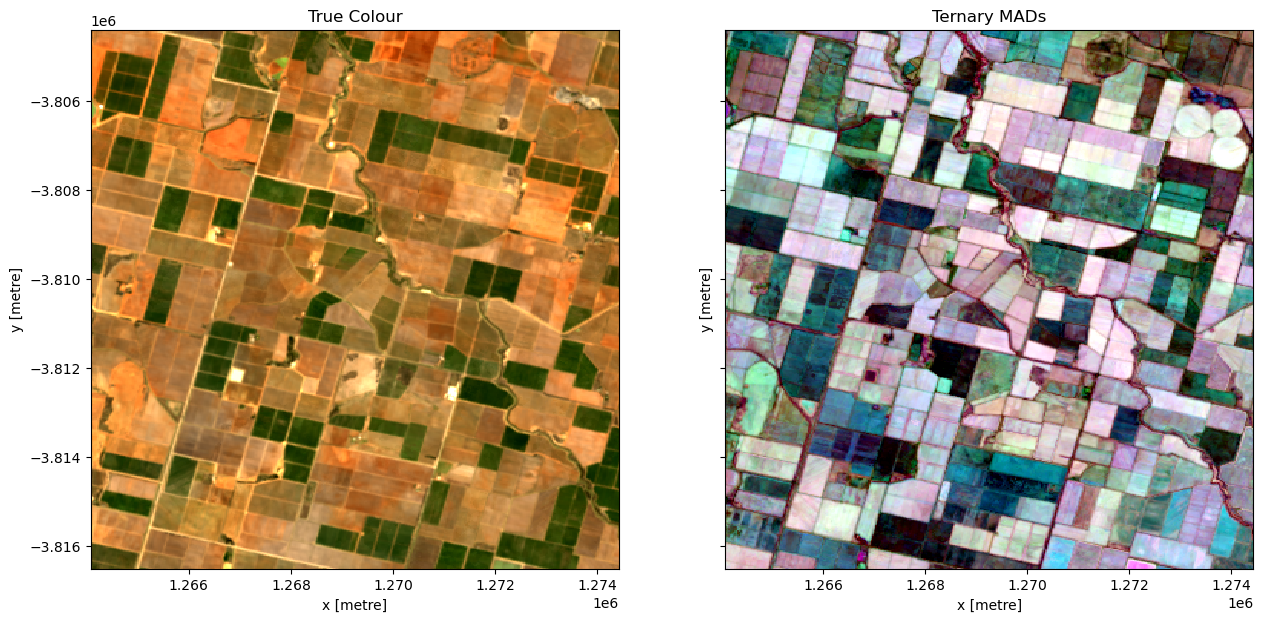

In [10]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
rgb(ds, ax=ax[0], bands=["red", "green", "blue"])
rgb(ds, bands=["sdev", "edev", "bcdev"], ax=ax[1])
ax[0].set_title("True Colour")
ax[1].set_title("Ternary MADs");

### Example 3: Identifying irrigated areas using SDEV

The following section will demonstrate a simple analysis workflow based on the GeoMAD product. 
In this example, we will threshold the SDEV band to distinguish irrigated agricultural fields from rain-fed agricultural fields.

First, lets reload our data over the same region as above. We will load the `red`, `green`, and `blue` bands, along with `sdev`

In [11]:
# coordinates for AOI
lat, lon = -34.27566, 145.87389
buffer = 0.05

# combine central coordinates with buffer values to create the latitude and longitude range for the analysis
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# load data
ds = dc.load(
    product="ga_ls8c_nbart_gm_cyear_3",
    measurements=["red", "green", "blue", "sdev"],
    x=(lon - buffer, lon + buffer),
    y=(lat + buffer, lat - buffer),
    time=("2015"),
)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, y: 404, x: 345)
Coordinates:
  * time         (time) datetime64[ns] 2015-07-02T11:59:59.999999
  * y            (y) float64 -3.804e+06 -3.804e+06 ... -3.816e+06 -3.816e+06
  * x            (x) float64 1.264e+06 1.264e+06 ... 1.274e+06 1.274e+06
    spatial_ref  int32 3577
Data variables:
    red          (time, y, x) int16 1082 1114 1176 1161 ... 1047 1087 1111 1052
    green        (time, y, x) int16 787 866 883 837 841 ... 844 815 830 851 814
    blue         (time, y, x) int16 524 559 579 550 560 ... 611 579 591 603 575
    sdev         (time, y, x) float32 0.001115 0.004531 ... 0.0008823 0.001321
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


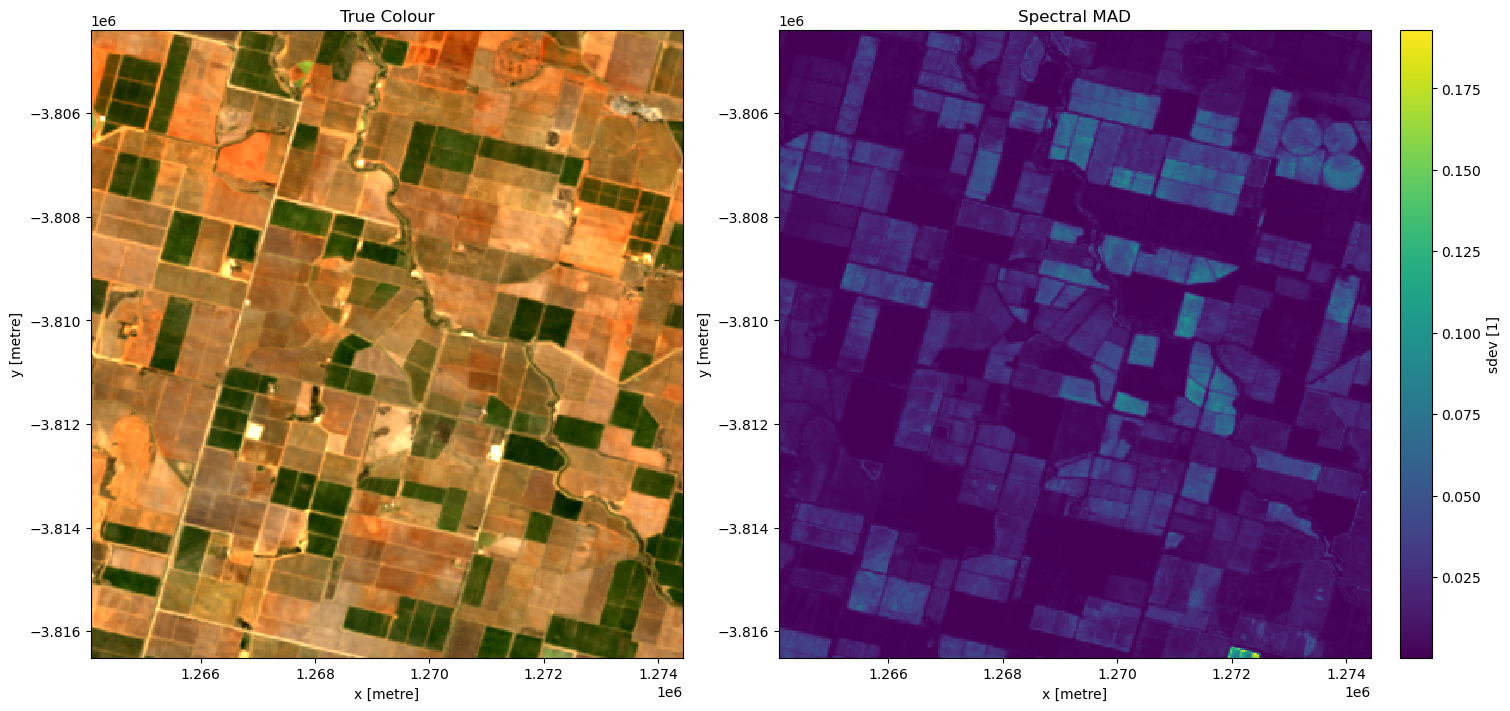

In [12]:
f, axarr = plt.subplots(1, 2, figsize=(15, 7), squeeze=False, layout="constrained")
rgb(ds, bands=["red", "green", "blue"], ax=axarr[0, 0])
ds.sdev.plot(ax=axarr[0, 1], cmap="viridis")
axarr[0, 0].set_title("True Colour")
axarr[0, 1].set_title("Spectral MAD")
plt.show()

It looks like `smad` will be useful for identifying irrigation, so lets define a threshold using the `skimage.filters.threshold_li` method. 
This method will automatically find the optimal threhold based on minimizing the cross-entropy between the foreground and the foreground mean, and the background and the background mean.

Threshold:  0.012803578


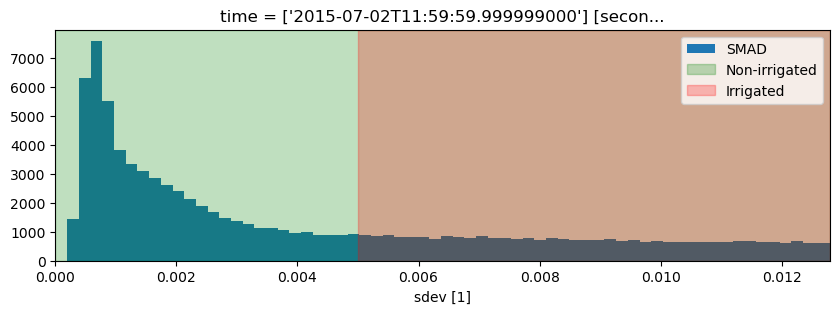

In [13]:
from skimage.filters import threshold_li

# find the threshold
threshold = threshold_li(ds.sdev.values)
print("Threshold: ", threshold)

# plot a histogram of the result
fig, ax = plt.subplots(figsize=(10, 3))
ds.sdev.plot.hist(bins=1000, label="SMAD")
plt.xlim(0, 0.0128)
ax.axvspan(xmin=0, xmax=threshold, alpha=0.25, color="green", label="Non-irrigated"),
ax.axvspan(xmin=threshold, xmax=0.005, alpha=0.25, color="red", label="Irrigated")
plt.legend();

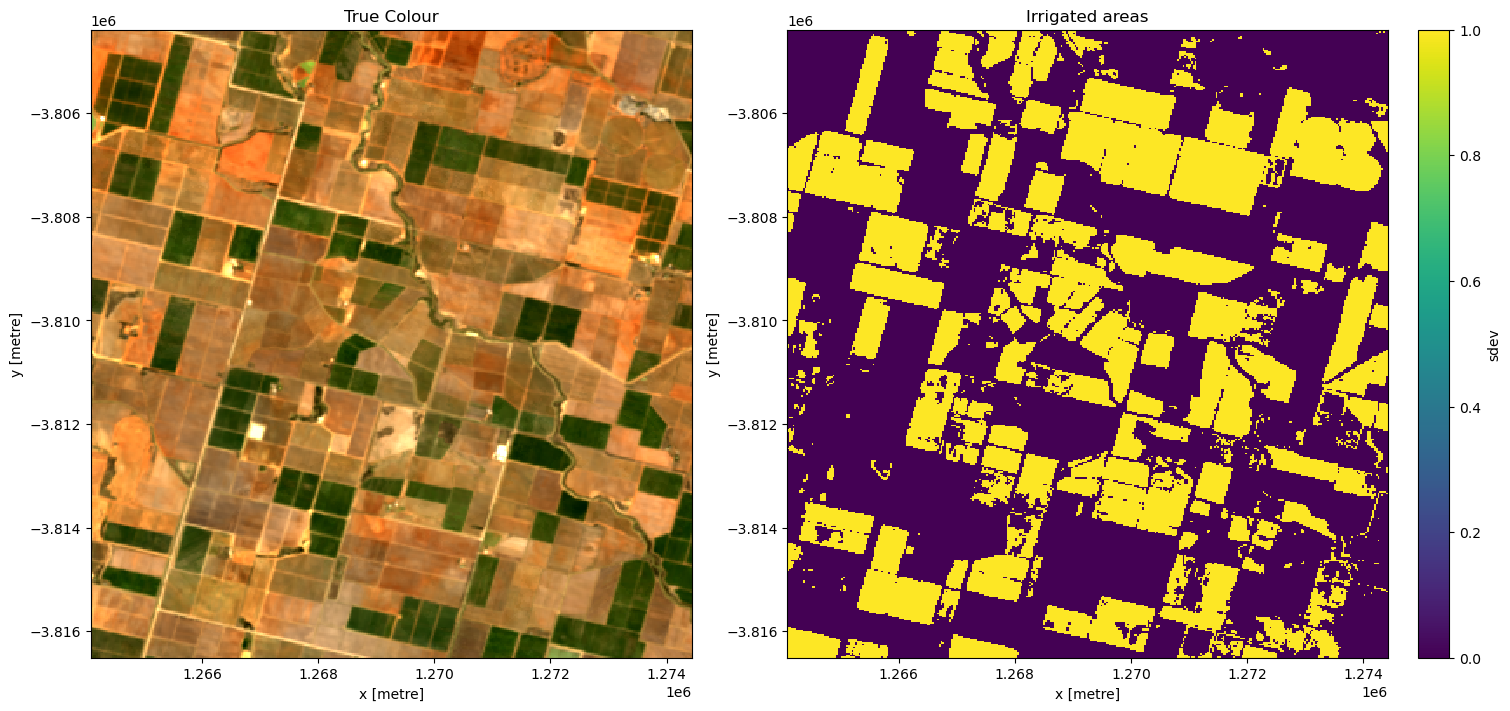

In [14]:
# apply the threshold
irrigated = ds.sdev >= threshold

# plot
f, axarr = plt.subplots(1, 2, figsize=(15, 7), squeeze=False, layout="constrained")
rgb(ds, bands=["red", "green", "blue"], ax=axarr[0, 0])
irrigated.plot(ax=axarr[0, 1])
axarr[0, 0].set_title("True Colour")
axarr[0, 1].set_title("Irrigated areas")
plt.show()

## Interactive widget: Understanding the geomedian

<img src="../Supplementary_data/DEA_GeoMAD/widget.png">

*An example of the geomedian interactive widget.*

> The Digital Earth Australia Docs website is read-only. Log in to the [Digital Earth Australia Sandbox](https://app.sandbox.dea.ga.gov.au/) and navigate to the **Datasets** folder > **GeoMAD** to interact with the widget.

In this interactive widget example, you have a dataset of Earth observation satellite data. It contains the red, green, and blue bands, which are the bands generally used to generate colour images. The widget focuses on a single pixel that has data for 3 different timesteps. We can composite (combine) these 3 timesteps into one using a statistical composition method such as `median` or `geomedian`.

This widget shows that the median does **not** always account for very large or very small band values, and may not be particularly representative of the variation we see in the three timesteps. 

Variation is better incorporated into the `Geomedian RGB - All timesteps` result, as the geomedian formula treats each timestep as a multi-dimensional vector. We see this results in differing values between the median and geomedian.

In [15]:
geomedian.run_app()

For example, try:

>Timestep 1: (0,0,0)

>Timestep 2: (0, 255, 0)

>Timestep 3: (255, 255, 255)

The geomedian shows a more representative value that incorporates some of the variation across the timesteps.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [16]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)